Load packages required:

In [1]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
from math import sqrt

Implement Algorithm 1:

In [2]:
def strategies(S,N):
    
    def tobase(x, base=S+1, digits=N):
        output = []
        for i in range(digits):
            power = digits - i - 1
            newdigit = x // (base**power)
            x -= newdigit*base**power
            output.append(newdigit)
            
        return output
    strategies = [tobase(x) for x in range((S+1)**N + 1)]
    
    return [item for item in strategies if sum(item) == S]

Implement Algorithm 2:


In [3]:
def payoff1(s1, s2):
    wins = [p1 >= p2 for p1,p2 in zip(s1, s2)]
    return sum(wins)

def payoff2(s1, s2):
    return len(s1) - payoff1(s1, s2)

In [4]:
#Calculate possible actions and payoff matrices for Blotto game
strategy = strategies(5,3)
n = len(strategy)
A = np.zeros((n,n))
B = np.zeros((n,n))

for i in range(0,n):
    for j in range(0,n):
        A[i,j] = payoff1(strategy[i], strategy[j])
        B[i,j] = payoff2(strategy[i], strategy[j])

Implement Algorithm 3:

In [5]:
# Implement regret learning algorithm
def swap(j, k, A, p1actions, p2actions, time):
    xaction = p1actions[time-1]
    yaction = p2actions[time-1]
    if xaction == j:
        return A[k,yaction]
    else:
        return A[xaction,yaction]

def diff(j, k, A, p1actions, p2actions, time):
    return sum([swap(j, k, A, p1actions, p2actions, t) - A[p1actions[t-1], p2actions[t-1]] for t in range(1,time+1)])/time
 
def regret(j, k, A, p1actions, p2actions, time):
    return max(0, diff(j, k, A, p1actions, p2actions, time))
    
def HMC(A, B, runtime, mu):
    n = np.shape(A)[0]
    m = np.shape(A)[1]
    t = 1

    p1actions = [0]
    p2actions = [0]
    
    extras = []
    specialtimes = [100,200,500,1000,2000,5000,10000,20000]
    
    # Implement regret learning for t > 1
    while t < runtime:
        
        latest1 = p1actions[-1]
        latest2 = p2actions[-1]
        
        #Calculate regrets
        regret1 = [regret(latest1, k, A, p1actions, p2actions, t) for k in range(n)]
        regret2 = [regret(latest2, k, B, p1actions, p2actions, t) for k in range(m)]
        
        prob1 = [regret/mu for regret in regret1]
        prob2 = [regret/mu for regret in regret2]
        
        prob1[latest1] = 1 - sum(prob1)
        prob2[latest2] = 1 - sum(prob2)
        
        p1actions.append(rand.choice(n, p=prob1))
        p2actions.append(rand.choice(m, p=prob2))
        
        t += 1
        
        if t in specialtimes:
            extraregrets = [regret(5, 20, A, p1actions, p2actions, t), regret(20, 16, A, p1actions, p2actions, t),
                            regret(4, 6, B, p1actions, p2actions, t), regret(20, 18, B, p1actions, p2actions, t)]
            extras.append(extraregrets)
        
    result1 = [p1actions.count(k)/runtime for k in range(n)]
    result2 = [p2actions.count(k)/runtime for k in range(m)]
    extras = np.array(extras)
    
    return [result1, result2, extras, p1actions, p2actions]

In [6]:
#Run regret learning algorithm for Blotto game
rand.seed(1635)
results = HMC(A,B,20000,40.1)

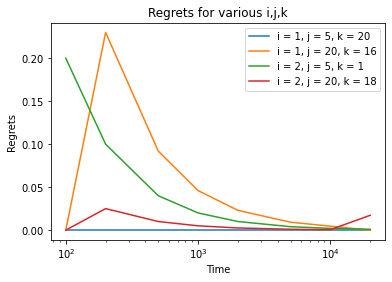

In [7]:
#Plot regrets for certain i,j,k against time
x = [100,200,500,1000,2000,5000,10000,20000]
regrets = results[2]
plt.plot(x, regrets[:,0], label = "i = 1, j = 5, k = 20")
plt.plot(x, regrets[:,1], label = "i = 1, j = 20, k = 16")
plt.plot(x, regrets[:,2], label = "i = 2, j = 5, k = 1")
plt.plot(x, regrets[:,3], label = "i = 2, j = 20, k = 18")

plt.title('Regrets for various i,j,k')
plt.ylabel('Regrets')
plt.xlabel('Time')
plt.legend()

plt.xscale('log')
#plt.savefig('conv1.png') Uncomment to save figure
plt.show()

In [8]:
#Find IDs of most popular actions
p1results = results[0]
significant1 = [i for i in range(21) if p1results[i] > 0.1]
p2results = results[1]
significant2 = [i for i in range(21) if p2results[i] > 0.1]
print(significant1)
print(significant2)

[11, 20]
[5, 11, 20]


In [9]:
#Find popular actions for player 1
[strategy[i] for i in significant1]

[[2, 0, 3], [5, 0, 0]]

In [10]:
#Find popular actions for player 2
[strategy[i] for i in significant2]

[[0, 5, 0], [2, 0, 3], [5, 0, 0]]

In [23]:
#Calculate empirical distribution of pairs of actions
p1actions = results[3]
p2actions = results[4]
pij = np.zeros((21,21))
for i,j in zip(p1actions,p2actions):
        pij[i,j] += 1
pij = pij/20000

CE = []
for i in range(21):
    for idash in range(21):
            value = np.dot(A[idash,:], pij[i,:]) - np.dot(A[i,:], pij[i,:])
            CE.append(value)
for j in range(21):
    for jdash in range(21):
            value = np.dot(B[:,jdash], pij[:,j]) - np.dot(B[:,j], pij[:,j])
            CE.append(value)
print(len(CE))
#Calculate how many inequalities are more than x away from being satisfied:
print(sum([1 for k in CE if k >= 0.01]))
print(sum([1 for k in CE if k >= 0.05]))

882
187
42


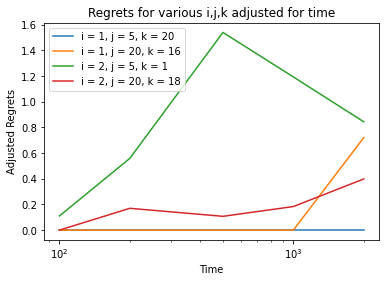

In [12]:
#Estimate expected value of adjusted regret and plot vs time
rand.seed(6482)
regretsim = []
for i in range(10):
    newresults = HMC(A,B,2000,40.1)[2]
    regretsim.append(newresults)
    
regretsim = sum(regretsim)/10

x = [100,200,500,1000,2000]
y0 = [a*sqrt(b) for a,b in zip(regretsim[:,0],x)]
y1 = [a*sqrt(b) for a,b in zip(regretsim[:,1],x)]
y2 = [a*sqrt(b) for a,b in zip(regretsim[:,2],x)]
y3 = [a*sqrt(b) for a,b in zip(regretsim[:,3],x)]

plt.plot(x, y0, label = "i = 1, j = 5, k = 20")
plt.plot(x, y1, label = "i = 1, j = 20, k = 16")
plt.plot(x, y2, label = "i = 2, j = 5, k = 1")
plt.plot(x, y3, label = "i = 2, j = 20, k = 18")

plt.title('Regrets for various i,j,k adjusted for time')
plt.ylabel('Adjusted Regrets')
plt.xlabel('Time')
plt.legend()

plt.xscale('log')
#plt.savefig('conv2.png') Uncomment to save figure
plt.show()